In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter

import networkx as nx
import pygraphviz as pgv

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors
from matplotlib import colors

# for colab
#from google.colab import drive 
#drive.mount('/content/drive')
#%cd /content/drive/MyDrive/

# Loading and formatting the data

In [65]:
# load the data on followers
df = pd.read_csv('d_following_all.csv', index_col=0).reset_index()
df['account'] = [name.split('@')[1] for name in df.account]

# load the list of people
d_people = pd.read_excel('List of programmes.xlsx', sheet_name='People', index_col=0)

# load the institutions
d_inst = pd.read_excel('List of programmes.xlsx', sheet_name='Research Institutes', index_col=0)

# load the retweet data
d_rt = pd.read_excel('tweets_180522_180523.xlsx', index_col=1)

# load the closed coding data
d_cc = pd.read_excel('final_categorised_data.xlsx', index_col=1)

# how many twitter handles from SODAS people do we have?
sum([True for i in d_people.Twitter_handle if i != '-'])

275

In [3]:
# takes a long time: ~5 min - consider saving as csv

# empty list - will be filled with tuples: (retweeter, retweeted) or (tweeter, mentioned)
rt_edges = []

# looping through all tweets
for i, tweet in enumerate(d_rt.text):
    # handling the tweets and RT differently - we want only the person being retweeted, but all people being mentioned in original tweets

    # all RT start with RT
    if tweet[0:2] == 'RT':
        # appending tuple of (account, retweeted account)
        rt_edges.append((list(d_rt.account)[i].split('@')[1], tweet.split(' ')[1][1:-1]))

    # if tweet doesn't start with RT, then it is an original tweet
    else:
        # checking if the tweet even mention people
        if '@' in tweet:
            # looing through all accounts mentioned
            for account in [i for i in tweet.split(' ') if '@' in i]:
               # cleaning account name
               account = re.sub(r'[^\w\s]','',account)
               # appending tuple to list (tweeter, mentioned)
               rt_edges.append((list(d_rt.account)[i].split('@')[1], account)) 
    # status - how far are we?
    if i % 1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000


<Axes: >

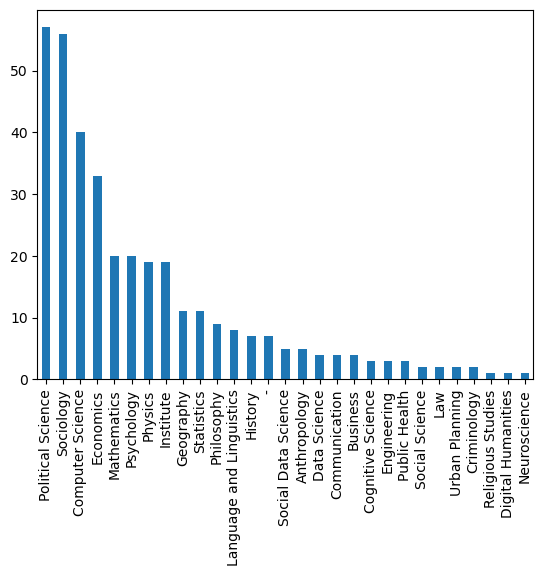

In [67]:
# list of all departments/institutes
l_departments = [i.split('@')[1] for i in d_inst.Twitter_handle]

# list departments/institutes background - aka institute
l_departments_bg = ['Institute'] * len(l_departments)

# creating dictionary of peoples backgrounds
dict_background = dict(zip([i.split('@')[1] if i != '-' else '-' for i in d_people.Twitter_handle] + l_departments, 
                           list(d_people.Disciplinary_background_grouped) + l_departments_bg))

# list of backgrounds
bgs = []
for i in dict_background.values():
    bgs.extend(i.split('; '))

# set of backgrounds (only unique values)
set_bg = set(bgs)

# making a list of people and institutes
l_people = [name.split('@')[1] for name in d_people.Twitter_handle if name != '-'] + [name.split('@')[1] for name in d_inst.Twitter_handle if name != '-']

# list of people in our RT network
rt_people = np.unique([i[0] for i in rt_edges])

# subsetting the dataframe - so we only have following connections within SODAS
df_network = df[df['following'].isin(l_people)]

# creating follower edges
followers_edges = list(zip(df_network.account, df_network.following))

# filtering out everybody not from in our sodas list
rt_edges_sodas = [i for i in rt_edges if (i[1] in rt_people) and i[0] != i[1]] 

# d_edge = pd.DataFrame(rt_edges_sodas).set_axis(['source','target'],axis='columns')

# d_edge['background'] = [dict_background[i] for i in d_edge.source]

# d_edge['uni'] = [uni_affiliation[i] for i in d_edge.source]

# weights for weighted edges
dict_w_edges = dict(Counter(rt_edges_sodas))

# list of tuples (tweeter, mentioned, weight) - weight being how many times the pair occured in the data
rt_w_edges_sodas = list(zip([i[0] for i in dict_w_edges.keys()],
                            [i[1] for i in dict_w_edges.keys()],
                            dict_w_edges.values()))

# list of 'Institute'
l_departments_uni = ['Institute'] * len(l_departments)

# dict for uniaffiliation
uni_affiliation = dict(zip([i.split('@')[1] if i != '-' else '-' for i in d_people.Twitter_handle] + 
                           [i.split('@')[1] if i != '-' else '-' for i in d_inst.Twitter_handle], 
                           list(d_people.University) + list(d_inst.index)))

# unique universities
set_uni = set(list(uni_affiliation.values()))

# random colors for each uni - maybe actually choose colors for each uni
#uni_color = dict(zip(set_uni, list(mcolors.CSS4_COLORS)[0:len(set_uni)]))

# filtering d_people
d_people_sub = d_people[d_people.Twitter_handle != '-']

# list of Disciplinary_background_grouped - keep in the code
#l = [i.split('; ') for i in d_people_sub.Disciplinary_background_grouped if len(i.split('; ')) != 1]
#set([item for sublist in l for item in sublist])

## closed coding ##
# cleaning
d_cc['account_clean'] = [i.split('@')[1] for i in d_cc['account']]

# aggegating and finding mean for each person (how much they tweet about the different subjects)
d_cc_agg = d_cc.groupby('account_clean')\
    .agg({'automated_text_analysis':'mean',
          'networks':'mean',
          'statistics':'mean',
          'machine_learning':'mean',
          'netnography':'mean',
          'ethics_about_technology':'mean'}) \
    .reset_index()

# normalizing and creating a dictionary
dict_ata = dict(zip(d_cc_agg['account_clean'], d_cc_agg['automated_text_analysis']/max(d_cc_agg['automated_text_analysis'])))
dict_netw = dict(zip(d_cc_agg['account_clean'], d_cc_agg['networks']/max(d_cc_agg['networks'])))
dict_stat = dict(zip(d_cc_agg['account_clean'], d_cc_agg['statistics']/max(d_cc_agg['statistics'])))
dict_ml = dict(zip(d_cc_agg['account_clean'], d_cc_agg['machine_learning']/max(d_cc_agg['machine_learning'])))
dict_netn = dict(zip(d_cc_agg['account_clean'], d_cc_agg['netnography']/max(d_cc_agg['netnography'])))
dict_ethic = dict(zip(d_cc_agg['account_clean'], d_cc_agg['ethics_about_technology']/max(d_cc_agg['ethics_about_technology'])))

# consider deleting #
len_ata = len(d_cc[d_cc['automated_text_analysis'] == 1])

d_ata_cat = d_cc[d_cc['automated_text_analysis'] == 1].groupby('account_clean')\
    .agg({'automated_text_analysis':'count'})

d_ata_cat['ata_norm'] = d_ata_cat['automated_text_analysis']/len_ata
d_ata_cat['ata_norm2'] = d_ata_cat['ata_norm']/max(d_ata_cat['ata_norm'])
#####################

pd.Series(bgs).value_counts().plot(kind='bar')

In [170]:
l89 = dict(d_rt.groupby(['account'])['account'].count())
max(l89, key=l89.get)


' @tforcworc'

In [28]:
# dictionaries matching backgrounds and colors

dict_interdis = {'Political Science': 'seagreen',
                     'Sociology': 'mediumseagreen', 
                     'Economics': 'DarkSeaGreen',
                     'Psychology': 'lightgreen',
                     'Anthropology' : 'palegreen',
                     'Public Health' : 'greenyellow', # confere
                     'Criminology' : 'yellowgreen', # confere
                     'Law' : 'forestgreen', # confere
                     'Urban Planning' : 'green',
                     'Social Science' : 'limegreen',
                     'Neuroscience' : 'darkgreen', # confere
                     'Social Data Science' : 'lavender', # mix green purple
                     'Business' : 'springgreen',
                     'Cognitive Science' : 'mediumspringgreen',
                     'Computer Science': 'mediumorchid', 
                     'Mathematics': 'plum',
                     'Physics': 'orchid',
                     'Statistics': 'rebeccapurple',
                     'Data Science' : 'purple', # maybe change
                     'Engineering' : 'darkorchid',
                     'Geography' : 'slategrey', # mix
                     'Philosophy' : 'gold', 
                     'Language and Linguistics' : 'goldenrod',
                     'History' : 'orange',
                     'Communication' : 'sandybrown',
                     'Religious Studies' : 'darkgoldenrod',
                     'Digital Humanities' : 'pink', # mix
                     'Institute' : 'grey',
                     '-' : 'white'}

dict_large_groups = {'Political Science': 'seagreen',
                     'Sociology': 'mediumseagreen', 
                     'Economics': 'DarkSeaGreen',
                     'Psychology': 'lightgreen',
                     'Computer Science': 'mediumorchid', 
                     'Mathematics': 'plum',
                     'Physics': 'orchid',
                     'Statistics': 'rebeccapurple',
                     'Geography' : 'slategrey',
                     'Philosophy' : 'gold', 
                     'Language and Linguistics' : 'goldenrod',
                     'History' : 'orange',
                     'Institute' : 'grey'}

dict_large_groups = {'Political Science': 'seagreen',
                     'Sociology': 'mediumseagreen', 
                     'Economics': 'DarkSeaGreen',
                     'Psychology': 'lightgreen',
                     'Computer Science': 'mediumorchid', 
                     'Mathematics': 'plum',
                     'Physics': 'orchid',
                     'Institute' : 'grey'}


set_uni = set([item for sublist in [i.split('; ') for i in uni_affiliation.values()] for item in sublist])

uni_color = {'Columbia University': 'cornflowerblue',
 'University of Edinburgh': 'lightcoral',
 'Aalborg University': 'darkblue',
 'DTU - Technical University of Denmark': 'darksalmon',
 'University of Exeter': 'lightgreen',
 'University of Oxford': 'gold',
 'Lund University': 'lightsalmon',
 'University of Sussex': 'darkcyan',
 'University of Massachusetts Amherst': 'lightskyblue',
 'University College London': 'lightyellow',
 'University of Copenhagen': '#901A1E',
 'University of Helsinki': 'linen',
 'University of Toulouse': 'coral',
 'Brown': 'brown',
 'Edinburgh University': 'cornsilk',
 'University of Amsterdam': 'darkorange',
 'Trinity College Dublin': 'mediumturquoise',
 'Linköping University': 'deepskyblue',
 'University of Maryland': 'red2',
 'University College Dublin': 'darkgreen',
 'Central European University': 'darkturquoise',
 'University of Cambridge': 'red',
 'Penn State University': 'mediumblue',
 'University of Hong Kong': 'darkseagreen',
 'University of Warwick': 'darkorchid',
 'University of Chicago': 'mediumvioletred',
 'University of California in L.A.': 'mediumslateblue',
 'University of Essex': 'mediumpurple',
 'Katholieke Universiteit Leuven': 'mediumblue',
 'University of Texas at Dallas': 'orange',
 'University of Southern Denmark': 'mediumaquamarine',
 'IT University of Copenhagen': 'chocolate1',
 'University at Buffalo': 'mediumslateblue',
 'Queen Mary University of London': 'darkmagenta',
 'University of Konstanz': 'mediumseagreen',
 'London School of Economics': 'firebrick1',
 'University of Manchester': 'mediumorchid',
 'Universidad Carlos III de Madrid': 'mediumturquoise'}


In [58]:
position_color = dict(zip(list(set(d_people['Position_sorted'])) + ['Institute'], 
                          ['#F1BB7B', '#FD6467', 'firebrick', '#D67236', '#046C9A', 'grey']))

position_dict = dict(zip([i.split('@')[1] if i != '-' else '-' for i in d_people.Twitter_handle] + l_departments,
                         list(d_people.Position_sorted) + l_departments_bg))

# Tweet networks
Networks made from mentions and retweets

## Tweet network 1: Everthing is colored

In [34]:
# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in rt_w_edges_sodas:
    try:
        G.add_edge(i[0], i[1], 
                   weight = i[2], 
                   color = dict_interdis[dict_background[i[0]]], # color edge according to background
                   penwidth = np.sqrt(i[2])) # size of edge = sqrt(weight)
    except:
        G.add_edge(i[0], i[1], 
                   weight = i[2], 
                   color = dict_interdis[dict_background[i[0]].split('; ')[0]], # color edge according to first background 
                   penwidth = np.sqrt(i[2])) #  size of edge = sqrt(weight)

# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 1000 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    # finding the background of the node
    bg = dict_background[n].split('; ')

    # color for all with one background
    if len(bg) == 1:
        if dict_background[n] == 'Institute':
            n.attr['fontsize'] = '40'
        if dict_background[n] in dict_interdis.keys():
            n.attr['fillcolor'] = dict_interdis[dict_background[n]]
        else:
            n.attr['fillcolor'] = 'grey'
    # color for all with more backgrounds
    else:
        color = ''
        for i in bg:
            if i in dict_interdis.keys():
                color = color + dict_interdis[i] + ';' + str(round(1/len(bg),2)) + ':'
            else:
                color = color + 'grey;' + str(round(1/len(bg),2)) + ':'
        n.attr['fillcolor'] = color

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('RT_full_ratio2.png', prog = 'fdp', args='-Gsize=10000 -Gratio=2 -n2') 

#G.write("RTfull.dot")
#X3 = nx.nx_agraph.read_dot("RTfull.dot") 
#nx.write_gexf(X3, 'retweet_network_30-05.gexf')


/Users/orm/opt/anaconda3/envs/gt/lib/python3.11/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: fdp: graph is too large for cairo-renderer bitmaps. Scaling by 0.562794 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


## Tweet network: big groups 

In [21]:
# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in rt_w_edges_sodas:
    try:
        G.add_edge(i[0], i[1], 
                   weight = i[2], 
                   color = dict_interdis[dict_background[i[0]]], # color edge according to background
                   penwidth = np.sqrt(i[2])) # size of edge = sqrt(weight)
    except:
        G.add_edge(i[0], i[1], 
                   weight = i[2], 
                   color = dict_interdis[dict_background[i[0]].split('; ')[0]], # color edge according to first background 
                   penwidth = np.sqrt(i[2])) #  size of edge = sqrt(weight)

# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 1000 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    # finding the background of the node
    bg = dict_background[n].split('; ')

    # color for all with one background
    #if len(bg) == 1:
    #    if dict_background[n] in dict_large_groups.keys():
    #        n.attr['fillcolor'] = dict_large_groups[dict_background[n]]
    #    else:
    #        n.attr['fillcolor'] = 'white'
    #else:
    #    n.attr['fillcolor'] = 'white'

    if len(bg) == 1:
        if dict_background[n] == 'Institute':
            n.attr['fontsize'] = '40'
        if dict_background[n] in dict_large_groups.keys():
            n.attr['fillcolor'] = dict_large_groups[dict_background[n]]
        else:
            n.attr['fillcolor'] = 'white'
    # color for all with more backgrounds
    else:
        color = ''
        for i in bg:
            if i in dict_large_groups.keys():
                color = color + dict_large_groups[i] + ';' + str(round(1/len(bg),2)) + ':'
            else:
                color = color + 'white;' + str(round(1/len(bg),2)) + ':'
        n.attr['fillcolor'] = color

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('RT_biggroups_ratio2.png', prog = 'fdp', args='-Gsize=10000 -Gratio=2 -n2') 

## Tweet network: only interdiciplinary

In [28]:
# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in rt_w_edges_sodas:
    bg = dict_background[i[0]].split('; ')
    if len(bg) == 1:
        color_edge = 'grey'
    else:
        color_edge = ''
        for j in bg:
            if j in dict_interdis.keys():
                color_edge = color_edge + dict_interdis[j] + ';' + str(round(1/len(bg),2)) + ':'
            else:
                color_edge = color_edge + 'grey;' + str(round(1/len(bg),2)) + ':'
        #color_edge = dict_interdis[dict_background[i[0]].split('; ')[0]]
    
    G.add_edge(i[0], i[1], 
                   weight = i[2], 
                   color = color_edge, # color edge according to background
                   penwidth = np.sqrt(i[2])) # size of edge = sqrt(weight)

# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 1000 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    # finding the background of the node
    bg = dict_background[n].split('; ')

    if len(bg) != 1:
        color = ''
        for i in bg:
            if i in dict_interdis.keys():
                color = color + dict_interdis[i] + ';' + str(round(1/len(bg),2)) + ':'
            else:
                color = color + 'grey;' + str(round(1/len(bg),2)) + ':'
        n.attr['fillcolor'] = color
    elif dict_background[n] == 'Institute':
        n.attr['fillcolor'] = 'grey'
        n.attr['fontsize'] = '40'
    else:
        n.attr['fillcolor'] = 'white'

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('RT_interdiciplinary_ratio.png', prog = 'fdp', args='-Gsize=10000 -Gratio=2 -n2') 

/Users/orm/opt/anaconda3/envs/gt/lib/python3.11/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: fdp: graph is too large for cairo-renderer bitmaps. Scaling by 0.581377 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


## Social Science Network

In [37]:
socsci = ['Political Science',
                     'Sociology', 
                     'Economics',
                     'Psychology',
                     'Anthropology',
                     'Public Health', # confere
                     'Criminology', # confere
                     'Law', # confere
                     'Urban Planning',
                     'Social Science',
                     'Neuroscience', # confere
                     'Social Data Science', # mix green purple
                     'Business',
                     'Cognitive Science',
                     'Institute']


# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in rt_w_edges_sodas:
    bg = dict_background[i[0]].split('; ')
    color_edge = ''
    for j in bg:
        if j in socsci:
            color_edge = color_edge + dict_interdis[j] + ';' + str(round(1/len(bg),2)) + ':'
        else:
            color_edge = color_edge + 'grey;' + str(round(1/len(bg),2)) + ':'
        #color_edge = dict_interdis[dict_background[i[0]].split('; ')[0]]
    
    G.add_edge(i[0], i[1], 
                   weight = i[2], 
                   color = color_edge, # color edge according to background
                   penwidth = np.sqrt(i[2])) # size of edge = sqrt(weight)

# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 1000 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    # finding the background of the node
    bg = dict_background[n].split('; ')

    # color for all with one background
    if len(bg) == 1:
        if dict_background[n] == 'Institute':
            n.attr['fontsize'] = '40'
        if dict_background[n] in socsci:
            n.attr['fillcolor'] = dict_interdis[dict_background[n]]
        else:
            n.attr['fillcolor'] = 'white'
    # color for all with more backgrounds
    else:
        color = ''
        for i in bg:
            if i in socsci:
                color = color + dict_interdis[i] + ';' + str(round(1/len(bg),2)) + ':'
            else:
                color = color + 'white;' + str(round(1/len(bg),2)) + ':'
        n.attr['fillcolor'] = color

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('RT_socsci.png', prog = 'fdp', args='-Gsize=10000 -Gratio=2 -n2') 

/Users/orm/opt/anaconda3/envs/gt/lib/python3.11/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: fdp: graph is too large for cairo-renderer bitmaps. Scaling by 0.581377 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


## DatSci Network

In [40]:
datsci = ['Computer Science',
                     'Mathematics',
                     'Physics',
                     'Statistics',
                     'Data Science', # maybe change
                     'Engineering',
                     'Geography', # mix
                     'Institute']

# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in rt_w_edges_sodas:
    bg = dict_background[i[0]].split('; ')
    color_edge = ''
    for j in bg:
        if j in datsci:
            color_edge = color_edge + dict_interdis[j] + ';' + str(round(1/len(bg),2)) + ':'
        else:
            color_edge = color_edge + 'grey;' + str(round(1/len(bg),2)) + ':'
        #color_edge = dict_interdis[dict_background[i[0]].split('; ')[0]]
    
    G.add_edge(i[0], i[1], 
                   weight = i[2], 
                   color = color_edge, # color edge according to background
                   penwidth = np.sqrt(i[2])) # size of edge = sqrt(weight)

# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 1000 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    # finding the background of the node
    bg = dict_background[n].split('; ')

    # color for all with one background
    if len(bg) == 1:
        if dict_background[n] == 'Institute':
            n.attr['fontsize'] = '40'
        if dict_background[n] in datsci:
            n.attr['fillcolor'] = dict_interdis[dict_background[n]]
        else:
            n.attr['fillcolor'] = 'white'
    # color for all with more backgrounds
    else:
        color = ''
        for i in bg:
            if i in datsci:
                color = color + dict_interdis[i] + ';' + str(round(1/len(bg),2)) + ':'
            else:
                color = color + 'white;' + str(round(1/len(bg),2)) + ':'
        n.attr['fillcolor'] = color

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('RT_datsci.png', prog = 'fdp', args='-Gsize=10000 -Gratio=2 -n2') 

## HUM-Net

In [76]:
humsci = ['Philosophy', 
          'Language and Linguistics',
          'History',
          'Communication',
          'Religious Studies',
          'Digital Humanities', # mix
          'Institute']

# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in rt_w_edges_sodas:
    bg = dict_background[i[0]].split('; ')
    color_edge = ''
    for j in bg:
        if j in humsci:
            color_edge = color_edge + dict_interdis[j] + ';' + str(round(1/len(bg),2)) + ':'
        else:
            color_edge = color_edge + 'grey;' + str(round(1/len(bg),2)) + ':'
        #color_edge = dict_interdis[dict_background[i[0]].split('; ')[0]]
    
    G.add_edge(i[0], i[1], 
                   weight = i[2], 
                   color = color_edge, # color edge according to background
                   penwidth = np.sqrt(i[2])) # size of edge = sqrt(weight)

# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 1000 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    # finding the background of the node
    bg = dict_background[n].split('; ')

    # color for all with one background
    if len(bg) == 1:
        if dict_background[n] == 'Institute':
            n.attr['fontsize'] = '40'
        if dict_background[n] in humsci:
            n.attr['fillcolor'] = dict_interdis[dict_background[n]]
        else:
            n.attr['fillcolor'] = 'white'
    # color for all with more backgrounds
    else:
        color = ''
        for i in bg:
            if i in humsci:
                color = color + dict_interdis[i] + ';' + str(round(1/len(bg),2)) + ':'
            else:
                color = color + 'white;' + str(round(1/len(bg),2)) + ':'
        n.attr['fillcolor'] = color

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('RT_humsci.png', prog = 'fdp', args='-Gsize=10000 -Gratio=2 -n2')  


/Users/orm/opt/anaconda3/envs/gt/lib/python3.11/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: fdp: graph is too large for cairo-renderer bitmaps. Scaling by 0.581377 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


## Tweet network: Position network

In [59]:
# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in rt_w_edges_sodas:
    #try:
    G.add_edge(i[0], i[1], 
               weight = i[2], 
               color = position_color[position_dict[i[0]]], # color edge according to background
               penwidth = np.sqrt(i[2])) # size of edge = sqrt(weight)
    #except:
    #    G.add_edge(i[0], i[1], 
    #               weight = i[2], 
    #               color = dict_interdis[dict_background[i[0]].split('; ')[0]], # color edge according to first background 
    #               penwidth = np.sqrt(i[2])) #  size of edge = sqrt(weight)

# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 1000 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    # finding the background of the node
    #bg = dict_background[n].split('; ')

    if dict_background[n] == 'Institute':
        n.attr['fontsize'] = '40'

    n.attr['fillcolor'] = position_color[position_dict[n]]


# drawing the graph
G.draw('RT_position_ratio1.png', prog = 'fdp', args='-Gsize=10000 -Gratio=2 -n2') 

## Tweet network: university affiliation

In [50]:
# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in rt_w_edges_sodas:
    uni = uni_affiliation[i[0]].split('; ')
    color_edge = ''
    for j in uni:
        if j in uni_color.keys():
            color_edge = color_edge + uni_color[j] + ';' + str(round(1/len(uni),2)) + ':'
        else:
            color_edge = color_edge + 'grey;' + str(round(1/len(uni),2)) + ':'
    
    G.add_edge(i[0], i[1], 
                   weight = i[2], 
                   color = color_edge, # color edge according to background
                   penwidth = np.sqrt(i[2])) # size of edge = sqrt(weight)



# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 1000 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    # finding the background of the node
    uni = uni_affiliation[n].split('; ')

    if len(uni) == 1:
        if dict_background[n] == 'Institute':
            n.attr['fontsize'] = '40'
        if uni_affiliation[n] in uni_color.keys():
            n.attr['fillcolor'] = uni_color[uni_affiliation[n]]
        else:
            n.attr['fillcolor'] = 'white'
    else:
        color = ''
        for i in uni:
            if i in uni_color.keys():
                color = color + uni_color[i] + ';' + str(round(1/len(uni_affiliation),2)) + ':'
            else:
                color = color + 'grey;' + str(round(1/len(uni),2)) + ':'
        n.attr['fillcolor'] = color

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('RT_uni_ratio1.png', prog = 'fdp', args='-Gsize=10000 -Gratio=2 -n2') 

# Follower networks

## Follower network: full background

In [107]:
# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in followers_edges:
    bg = dict_background[i[0]].split('; ')
    color_edge = ''
    for j in bg:
        if j in dict_interdis.keys():
            color_edge = color_edge + dict_interdis[j] + ';' + str(round(1/len(bg),2)) + ':'
        else:
            color_edge = color_edge + 'grey;' + str(round(1/len(bg),2)) + ':'
        #color_edge = dict_interdis[dict_background[i[0]].split('; ')[0]]
    
    G.add_edge(i[0], i[1], 
                   color = color_edge) # color edge according to background


# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 200 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    # finding the background of the node
    bg = dict_background[n].split('; ')
    # color for all with one background
    if len(bg) == 1:
        if dict_background[n] == 'Institute':
            n.attr['fontsize'] = '100'
        if dict_background[n] in dict_interdis.keys():
            n.attr['fillcolor'] = dict_interdis[dict_background[n]]
        else:
            n.attr['fillcolor'] = 'white'
    # color for all with more backgrounds
    else:
        color = ''
        for i in bg:
            if i in dict_interdis.keys():
                color = color + dict_interdis[i] + ';' + str(round(1/len(bg),2)) + ':'
            else:
                color = color + 'white;' + str(round(1/len(bg),2)) + ':'
        n.attr['fillcolor'] = color

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('Follower_full_ratio.png', prog = 'fdp', args='-Gsize=20000 -Gratio=2 -n2') 

/Users/orm/opt/anaconda3/envs/gt/lib/python3.11/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: fdp: graph is too large for cairo-renderer bitmaps. Scaling by 0.189923 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


## SocNet - followers

In [104]:
# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in followers_edges:
    bg = dict_background[i[0]].split('; ')
    color_edge = ''
    for j in bg:
        if j in socsci:
            color_edge = color_edge + dict_interdis[j] + ';' + str(round(1/len(bg),2)) + ':'
        else:
            color_edge = color_edge + 'grey;' + str(round(1/len(bg),2)) + ':'
        #color_edge = dict_interdis[dict_background[i[0]].split('; ')[0]]
    
    G.add_edge(i[0], i[1], 
                   color = color_edge) # color edge according to background


# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 200 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    # finding the background of the node
    bg = dict_background[n].split('; ')
    # color for all with one background
    if len(bg) == 1:
        if dict_background[n] == 'Institute':
            n.attr['fontsize'] = '100'
        if dict_background[n] in socsci:
            n.attr['fillcolor'] = dict_interdis[dict_background[n]]
        else:
            n.attr['fillcolor'] = 'white'
    # color for all with more backgrounds
    else:
        color = ''
        for i in bg:
            if i in socsci:
                color = color + dict_interdis[i] + ';' + str(round(1/len(bg),2)) + ':'
            else:
                color = color + 'white;' + str(round(1/len(bg),2)) + ':'
        n.attr['fillcolor'] = color

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('Follower_socsci_ratio.png', prog = 'fdp', args='-Gsize=20000 -Gratio=2 -n2') 

## DatNet - followers

In [105]:
# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in followers_edges:
    bg = dict_background[i[0]].split('; ')
    color_edge = ''
    for j in bg:
        if j in datsci:
            color_edge = color_edge + dict_interdis[j] + ';' + str(round(1/len(bg),2)) + ':'
        else:
            color_edge = color_edge + 'grey;' + str(round(1/len(bg),2)) + ':'
        #color_edge = dict_interdis[dict_background[i[0]].split('; ')[0]]
    
    G.add_edge(i[0], i[1], 
                   color = color_edge) # color edge according to background


# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 200 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    # finding the background of the node
    bg = dict_background[n].split('; ')
    # color for all with one background
    if len(bg) == 1:
        if dict_background[n] == 'Institute':
            n.attr['fontsize'] = '100'
        if dict_background[n] in datsci:
            n.attr['fillcolor'] = dict_interdis[dict_background[n]]
        else:
            n.attr['fillcolor'] = 'white'
    # color for all with more backgrounds
    else:
        color = ''
        for i in bg:
            if i in datsci:
                color = color + dict_interdis[i] + ';' + str(round(1/len(bg),2)) + ':'
            else:
                color = color + 'white;' + str(round(1/len(bg),2)) + ':'
        n.attr['fillcolor'] = color

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('Follower_datsci_ratio.png', prog = 'fdp', args='-Gsize=20000 -Gratio=2 -n2') 

## HumNet - followers

In [106]:
# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in followers_edges:
    bg = dict_background[i[0]].split('; ')
    color_edge = ''
    for j in bg:
        if j in humsci:
            color_edge = color_edge + dict_interdis[j] + ';' + str(round(1/len(bg),2)) + ':'
        else:
            color_edge = color_edge + 'grey;' + str(round(1/len(bg),2)) + ':'
        #color_edge = dict_interdis[dict_background[i[0]].split('; ')[0]]
    
    G.add_edge(i[0], i[1], 
                   color = color_edge) # color edge according to background


# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 200 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    # finding the background of the node
    bg = dict_background[n].split('; ')
    # color for all with one background
    if len(bg) == 1:
        if dict_background[n] == 'Institute':
            n.attr['fontsize'] = '100'
        if dict_background[n] in humsci:
            n.attr['fillcolor'] = dict_interdis[dict_background[n]]
        else:
            n.attr['fillcolor'] = 'white'
    # color for all with more backgrounds
    else:
        color = ''
        for i in bg:
            if i in humsci:
                color = color + dict_interdis[i] + ';' + str(round(1/len(bg),2)) + ':'
            else:
                color = color + 'white;' + str(round(1/len(bg),2)) + ':'
        n.attr['fillcolor'] = color

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('Follower_humsci_ratio.png', prog = 'fdp', args='-Gsize=20000 -Gratio=2 -n2') 

/Users/orm/opt/anaconda3/envs/gt/lib/python3.11/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: fdp: graph is too large for cairo-renderer bitmaps. Scaling by 0.189923 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


## InterDis - followers

In [113]:
# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in followers_edges:
    bg = dict_background[i[0]].split('; ')
    color_edge = ''
    for j in bg:
        if len(bg) == 1:
            color_edge = 'grey'
        elif j in dict_interdis.keys():
            color_edge = color_edge + dict_interdis[j] + ';' + str(round(1/len(bg),2)) + ':'
        else:
            color_edge = color_edge + 'grey;' + str(round(1/len(bg),2)) + ':'
        #color_edge = dict_interdis[dict_background[i[0]].split('; ')[0]]
    
    G.add_edge(i[0], i[1], 
                   color = color_edge) # color edge according to background


# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 200 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    # finding the background of the node
    bg = dict_background[n].split('; ')
    # color for all with one background
    if len(bg) == 1:
        if dict_background[n] == 'Institute':
            n.attr['fontsize'] = '100'
            n.attr['fillcolor'] = 'grey'
        else:
            n.attr['fillcolor'] = 'white'
    # color for all with more backgrounds
    else:
        color = ''
        for i in bg:
            if i in dict_interdis.keys():
                color = color + dict_interdis[i] + ';' + str(round(1/len(bg),2)) + ':'
            else:
                color = color + 'white;' + str(round(1/len(bg),2)) + ':'
        n.attr['fillcolor'] = color

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('Follower_interdis_ratio1.png', prog = 'fdp', args='-Gsize=20000 -Gratio=2 -n2') 

/Users/orm/opt/anaconda3/envs/gt/lib/python3.11/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: fdp: graph is too large for cairo-renderer bitmaps. Scaling by 0.189923 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


## Follower network: University affiniation

In [62]:
# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in followers_edges:
    bg = uni_affiliation[i[0]].split('; ')
    color_edge = ''
    for j in bg:
        if j in uni_color.keys():
            color_edge = color_edge + uni_color[j] + ';' + str(round(1/len(bg),2)) + ':'
        else:
            color_edge = color_edge + 'grey;' + str(round(1/len(bg),2)) + ':'
        #color_edge = dict_interdis[dict_background[i[0]].split('; ')[0]]
    
    G.add_edge(i[0], i[1], 
                   color = color_edge) # color edge according to background


# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 200 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    # finding the background of the node
    uni = uni_affiliation[n].split('; ')
    # color for all with one background
    if len(uni) == 1:
        if n in l_departments:
            n.attr['fontsize'] = '100'
        if uni_affiliation[n] in uni_color.keys():
            n.attr['fillcolor'] = uni_color[uni_affiliation[n]]
        else:
            n.attr['fillcolor'] = 'white'
    # color for all with more backgrounds
    else:
        color = ''
        for j in uni:
            if j in uni_color.keys():
                color = color + uni_color[j] + ';' + str(round(1/len(uni),2)) + ':'
            else:
                color = color + 'white;' + str(round(1/len(uni),2)) + ':'
        n.attr['fillcolor'] = color

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('Follower_uniaffiliation_ratio.png', prog = 'fdp', args='-Gsize=20000 -Gratio=2 -n2') 

## Follower network: position

In [61]:
# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in followers_edges:
    bg = position_dict[i[0]].split('; ')
    color_edge = ''
    for j in bg:
        if j in position_color.keys():
            color_edge = color_edge + position_color[j] + ';' + str(round(1/len(bg),2)) + ':'
        else:
            color_edge = color_edge + 'grey;' + str(round(1/len(bg),2)) + ':'
        #color_edge = dict_interdis[dict_background[i[0]].split('; ')[0]]
    
    G.add_edge(i[0], i[1], 
                   color = color_edge) # color edge according to background


# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 200 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2
    
    #position_color[position_dict[i[0]]]
    
    # finding the background of the node
    pos = position_dict[n].split('; ')
    # color for all with one background
    if len(pos) == 1:
        if n in l_departments:
            n.attr['fontsize'] = '100'
        if position_dict[n] in position_color.keys():
            n.attr['fillcolor'] = position_color[position_dict[n]]
        else:
            n.attr['fillcolor'] = 'white'
    # color for all with more backgrounds
    else:
        color = ''
        for j in pos:
            if j in position_color.keys():
                color = color + position_color[j] + ';' + str(round(1/len(pos),2)) + ':'
            else:
                color = color + 'white;' + str(round(1/len(pos),2)) + ':'
        n.attr['fillcolor'] = color

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('Follower_uniaffiliation_ratio1.png', prog = 'fdp', args='-Gsize=20000 -Gratio=2 -n2') 

/Users/orm/opt/anaconda3/envs/gt/lib/python3.11/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: fdp: graph is too large for cairo-renderer bitmaps. Scaling by 0.189923 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


# CACA networks

In [63]:
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]

def rgb_to_hex(l):
    return '#{:02x}{:02x}{:02x}'.format(l[0], l[1], l[2])

ATA:    red       [#FD6467]
NETW:   purple    [#5a0166]
STAT:   pink      [#960291]
ML:     blue      [#0033ff]
NETN:   greenblue [#00A08A]
Ethics: green     [#0e5201]

## Tweet Network: Automated Text Analysis

In [82]:
# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in rt_w_edges_sodas:
    G.add_edge(i[0], i[1], 
        weight = i[2], 
        color = 'grey', # color edge according to background
        penwidth = np.sqrt(i[2])) # size of edge = sqrt(weight)

# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 1000 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    color = colors.to_hex(make_rgb_transparent(colors.colorConverter.to_rgb('#FD6467'), [1, 1, 1], dict_ata[n]**0.5))
    n.attr['fillcolor'] = color

    if dict_background[n] == 'Institute':
        n.attr['fontsize'] = '40'

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('RT_CACA_ATA_ratio.png', prog = 'fdp', args='-Gsize=10000 -Gratio=2 -n2') 

## Tweet Network: Networks

In [83]:
# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in rt_w_edges_sodas:
    G.add_edge(i[0], i[1], 
        weight = i[2], 
        color = 'grey', # color edge according to background
        penwidth = np.sqrt(i[2])) # size of edge = sqrt(weight)

# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 1000 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    color = colors.to_hex(make_rgb_transparent(colors.colorConverter.to_rgb('#5a0166'), [1, 1, 1], dict_netw[n]**0.5))
    n.attr['fillcolor'] = color

    if dict_background[n] == 'Institute':
        n.attr['fontsize'] = '40'

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('RT_CACA_network_ratio.png', prog = 'fdp', args='-Gsize=10000 -Gratio=2 -n2') 

## Tweet network: Statistics

In [101]:
# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in rt_w_edges_sodas:
    G.add_edge(i[0], i[1], 
        weight = i[2], 
        color = 'grey', # color edge according to background
        penwidth = np.sqrt(i[2])) # size of edge = sqrt(weight)

# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 1000 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    color = colors.to_hex(make_rgb_transparent(colors.colorConverter.to_rgb('#ff00dd'), [1, 1, 1], dict_stat[n]**0.5))
    n.attr['fillcolor'] = color

    if dict_background[n] == 'Institute':
        n.attr['fontsize'] = '40'

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('RT_CACA_stat_ratio_pink.png', prog = 'fdp', args='-Gsize=10000 -Gratio=2 -n2') 

## Tweet network: Machine Learning

In [102]:
# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in rt_w_edges_sodas:
    G.add_edge(i[0], i[1], 
        weight = i[2], 
        color = 'grey', # color edge according to background
        penwidth = np.sqrt(i[2])) # size of edge = sqrt(weight)

# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 1000 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    color = colors.to_hex(make_rgb_transparent(colors.colorConverter.to_rgb('#0033ff'), [1, 1, 1], dict_ml[n]**0.5))
    n.attr['fillcolor'] = color

    if dict_background[n] == 'Institute':
        n.attr['fontsize'] = '40'

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('RT_CACA_ml_ratio_blue.png', prog = 'fdp', args='-Gsize=10000 -Gratio=2 -n2') 

## Tweet network: Netnography

In [86]:
# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in rt_w_edges_sodas:
    G.add_edge(i[0], i[1], 
        weight = i[2], 
        color = 'grey', # color edge according to background
        penwidth = np.sqrt(i[2])) # size of edge = sqrt(weight)

# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 1000 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    color = colors.to_hex(make_rgb_transparent(colors.colorConverter.to_rgb('#00a08a'), [1, 1, 1], dict_netn[n]**0.5))
    n.attr['fillcolor'] = color

    if dict_background[n] == 'Institute':
        n.attr['fontsize'] = '40'

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('RT_CACA_netn_ratio.png', prog = 'fdp', args='-Gsize=10000 -Gratio=2 -n2') 

## Tweet network: Ethics

In [87]:
# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in rt_w_edges_sodas:
    G.add_edge(i[0], i[1], 
        weight = i[2], 
        color = 'grey', # color edge according to background
        penwidth = np.sqrt(i[2])) # size of edge = sqrt(weight)

# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 1000 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    color = colors.to_hex(make_rgb_transparent(colors.colorConverter.to_rgb('#0e5201'), [1, 1, 1], dict_ethic[n]**0.25))
    n.attr['fillcolor'] = color

    if dict_background[n] == 'Institute':
        n.attr['fontsize'] = '40'

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('RT_CACA_ethics_ratio.png', prog = 'fdp', args='-Gsize=10000 -Gratio=2 -n2') 

# Following CACA

## Follow ATA

In [90]:
# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in followers_edges:
    G.add_edge(i[0], i[1], color = 'grey') # color edge according to background

# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 200 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    if dict_background[n] == 'Institute':
        n.attr['fontsize'] = '100'
    
    if n in dict_ata.keys():
        n.attr['fillcolor'] = colors.to_hex(make_rgb_transparent(colors.colorConverter.to_rgb('#FD6467'), [1, 1, 1], dict_ata[n]**0.5))
    else:
        n.attr['fillcolor'] = 'white'

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('Follower_CACA_ATA_ratio.png', prog = 'fdp', args='-Gsize=20000 -Gratio=2 -n2') 

/Users/orm/opt/anaconda3/envs/gt/lib/python3.11/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: fdp: graph is too large for cairo-renderer bitmaps. Scaling by 0.189923 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


## Follow Networks

In [99]:
# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in followers_edges:
    G.add_edge(i[0], i[1], color = 'grey') # color edge according to background

# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 200 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    if dict_background[n] == 'Institute':
        n.attr['fontsize'] = '100'
    
    if n in dict_ata.keys():
        n.attr['fillcolor'] = colors.to_hex(make_rgb_transparent(colors.colorConverter.to_rgb('#5a0166'), [1, 1, 1], dict_netw[n]**0.5))
    else:
        n.attr['fillcolor'] = 'white'

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('Follower_CACA_networks_ratio.png', prog = 'fdp', args='-Gsize=20000 -Gratio=2 -n2') 

/Users/orm/opt/anaconda3/envs/gt/lib/python3.11/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: fdp: graph is too large for cairo-renderer bitmaps. Scaling by 0.270676 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


## Follow Stats

In [93]:
# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in followers_edges:
    G.add_edge(i[0], i[1], color = 'grey') # color edge according to background

# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 200 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    if dict_background[n] == 'Institute':
        n.attr['fontsize'] = '100'
    
    if n in dict_ata.keys():
        n.attr['fillcolor'] = colors.to_hex(make_rgb_transparent(colors.colorConverter.to_rgb('#960291'), [1, 1, 1], dict_stat[n]**0.5))
    else:
        n.attr['fillcolor'] = 'white'

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('Follower_CACA_stat_ratio_pink.png', prog = 'fdp', args='-Gsize=20000 -Gratio=2 -n2') 

/Users/orm/opt/anaconda3/envs/gt/lib/python3.11/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: fdp: graph is too large for cairo-renderer bitmaps. Scaling by 0.189923 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


## Follow Machine Learning

In [98]:
# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in followers_edges:
    G.add_edge(i[0], i[1], color = 'grey') # color edge according to background

# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 200 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    if dict_background[n] == 'Institute':
        n.attr['fontsize'] = '100'
    
    if n in dict_ata.keys():
        n.attr['fillcolor'] = colors.to_hex(make_rgb_transparent(colors.colorConverter.to_rgb('#0033ff'), [1, 1, 1], dict_ml[n]**0.5))
    else:
        n.attr['fillcolor'] = 'white'

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('Follower_CACA_ml_ratio.png', prog = 'fdp', args='-Gsize=20000 -Gratio=2 -n2') 

/Users/orm/opt/anaconda3/envs/gt/lib/python3.11/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: fdp: graph is too large for cairo-renderer bitmaps. Scaling by 0.24509 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


## Follow Netnography

In [95]:
# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in followers_edges:
    G.add_edge(i[0], i[1], color = 'grey') # color edge according to background

# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 200 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    if dict_background[n] == 'Institute':
        n.attr['fontsize'] = '100'
    
    if n in dict_ata.keys():
        n.attr['fillcolor'] = colors.to_hex(make_rgb_transparent(colors.colorConverter.to_rgb('#00A08A'), [1, 1, 1], dict_netn[n]**0.5))
    else:
        n.attr['fillcolor'] = 'white'

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('Follower_CACA_netnography_ratio.png', prog = 'fdp', args='-Gsize=20000 -Gratio=2 -n2') 

## Follow Ethics

In [96]:
# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in followers_edges:
    G.add_edge(i[0], i[1], color = 'grey') # color edge according to background

# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 200 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    if dict_background[n] == 'Institute':
        n.attr['fontsize'] = '100'
    
    if n in dict_ata.keys():
        n.attr['fillcolor'] = colors.to_hex(make_rgb_transparent(colors.colorConverter.to_rgb('#0e5201'), [1, 1, 1], dict_ethic[n]**0.5))
    else:
        n.attr['fillcolor'] = 'white'

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('Follower_CACA_ethics_ratio.png', prog = 'fdp', args='-Gsize=20000 -Gratio=2 -n2') 

In [148]:
is_max = d_cc_agg.eq(d_cc_agg.max(axis=1), axis=0)
d_cc_agg['max_CACA'] = is_max.dot(d_cc_agg.columns + " ")

d_cc_agg['max_CACA'] = [i[:-1] for i in d_cc_agg['max_CACA']]

alpha_mixed_caca = 0.5

CACA_colors = {'automated_text_analysis':colors.to_hex(make_rgb_transparent(colors.colorConverter.to_rgb('#FD6467'), [1, 1, 1], alpha_mixed_caca)),
               'networks':colors.to_hex(make_rgb_transparent(colors.colorConverter.to_rgb('#5a0166'), [1, 1, 1], alpha_mixed_caca)),
               'statistics':colors.to_hex(make_rgb_transparent(colors.colorConverter.to_rgb('#f500ed'), [1, 1, 1], alpha_mixed_caca)), # changed from #960291
               'machine_learning':colors.to_hex(make_rgb_transparent(colors.colorConverter.to_rgb('#0033ff'), [1, 1, 1], alpha_mixed_caca)),
               'netnography':colors.to_hex(make_rgb_transparent(colors.colorConverter.to_rgb('#00A08A'), [1, 1, 1], alpha_mixed_caca)),
               'ethics_about_technology':colors.to_hex(make_rgb_transparent(colors.colorConverter.to_rgb('#0e5201'), [1, 1, 1], alpha_mixed_caca))}

CACA_topics = dict(zip(d_cc_agg['account_clean'], d_cc_agg['max_CACA']))

/var/folders/mb/0425zkts7695hq57ytn4rk7m0000gn/T/ipykernel_4742/3879315077.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  is_max = d_cc_agg.eq(d_cc_agg.max(axis=1), axis=0)


## Tweet Network: mixed CACA

In [149]:
# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in rt_w_edges_sodas:
    cacas = CACA_topics[i[0]].split(' ')
    color_edge = ''
    for caca in cacas:
        if caca in CACA_colors.keys():
            color_edge = color_edge + CACA_colors[caca] + ';' + str(round(1/len(cacas),2)) + ':'
        else:
            color_edge = color_edge + 'grey;' + str(round(1/len(cacas),2)) + ':'

    G.add_edge(i[0], i[1], 
               weight = i[2], 
               color = color_edge, # color edge according to background
               penwidth = np.sqrt(i[2])) # size of edge = sqrt(weight)
    

# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 1000 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    # finding the background of the node
    cacas = CACA_topics[n].split(' ')

    # color for all with one background
    if len(cacas) == 1:
        if dict_background[n] == 'Institute':
            n.attr['fontsize'] = '40'
        n.attr['fillcolor'] = CACA_colors[CACA_topics[n]]
    # color for all with more backgrounds
    else:
        color = ''
        for i in cacas:
            if i in CACA_colors.keys():
                color = color + CACA_colors[i] + ';' + str(round(1/len(cacas),2)) + ':'
            else:
                color = color + 'grey;' + str(round(1/len(cacas),2)) + ':'
        n.attr['fillcolor'] = color

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('RT_full_caca.png', prog = 'fdp', args='-Gsize=10000 -Gratio=2 -n2') 

/Users/orm/opt/anaconda3/envs/gt/lib/python3.11/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: fdp: graph is too large for cairo-renderer bitmaps. Scaling by 0.55433 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


## Follow mixed CACA

In [158]:
# initializing the graph
G = pgv.AGraph(directed = True)

# looping through the list of edges and weights
for i in followers_edges:
    if i[0] in CACA_topics.keys():
        bg = CACA_topics[i[0]].split('; ')
        color_edge = ''
        for j in bg:
            if j in CACA_colors.keys():
                color_edge = color_edge + CACA_colors[j] + ';' + str(round(1/len(bg),2)) + ':'
            else:
                color_edge = color_edge + 'grey;' + str(round(1/len(bg),2)) + ':'
            #color_edge = dict_interdis[dict_background[i[0]].split('; ')[0]]
    else:
        color_edge = 'white'

    G.add_edge(i[0], i[1], 
                   color = color_edge) # color edge according to background


# attributes of the nodes
G.node_attr['style'] = 'wedged, filled'
G.node_attr["fontsize"] = "0"
G.node_attr['shape'] = 'circle'
G.node_attr["fixedsize"] = "shape"

# attributes of the graph
G.graph_attr['splines'] = 'spline' # 'curved' and 'spline' makes curved edges
G.graph_attr["outputorder"] = "edgesfirst" # nodes on top of edges
G.graph_attr['maxiter'] = 200 # lower maxiter speeds up the creation of the graph
G.graph_attr['dpi'] = 1000 # resolution of the graph

# dict with indegree
rt_degree = dict(zip(G.nodes(),G.in_degree()))

# looping through nodes 
for i in G.nodes():
    n = G.get_node(i) # n = user name

    # size of the nodes
    n.attr['width'] = np.sqrt(rt_degree[n])/2
    n.attr['height'] = np.sqrt(rt_degree[n])/2

    # finding the background of the node
    if n in CACA_topics.keys():
        bg = CACA_topics[n].split(' ')
        # color for all with one background
        if len(bg) == 1:
            if dict_background[n] == 'Institute':
                n.attr['fontsize'] = '100'
            if CACA_topics[n] in CACA_colors.keys():
                n.attr['fillcolor'] = CACA_colors[CACA_topics[n]]
            else:
                n.attr['fillcolor'] = 'white'
        # color for all with more backgrounds
        else:
            color = ''
            for i in bg:
                color = color + CACA_colors[i] + ';' + str(round(1/len(bg),2)) + ':'
            n.attr['fillcolor'] = color
    else:
        n.attr['fillcolor'] = 'white'

# extra info
# prog = "neato", "dot", "twopi", "circo", "fdp", "nop" # fdp =  Force-Directed Placement, args="-n2"

# drawing the graph
G.draw('Follower_mixed_CACA.png', prog = 'fdp', args='-Gsize=20000 -Gratio=2 -n2') 

/Users/orm/opt/anaconda3/envs/gt/lib/python3.11/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: fdp: graph is too large for cairo-renderer bitmaps. Scaling by 0.21768 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


# Graveyard

In [ ]:
{'-',
 'Anthropology', 
 'Business', 
 'Business Administration', # Business OK
 'Cognitive Science',
 'Communication',
 'Computational Social Science', #SDS OK
 'Computer Engineering', # Engineering OK
 'Computer Science',
 'Criminology', 
 'Data Science',
 'Digital Humanities',
 'Economics',
 'Economics ',
 'Engineering',
 'Geography',
 'Government', # Political Science OK
 'History',
 'History and Politics', # split up OK
 'Human Environment Relations', # Geography OK
 'Human Geography ', # Geography OK
 'Information Science', # CS OK
 'Institute', # grey
 'International Political Economy', #Econ OK
 'International Relations', #PS OK
 'Japanese Linguistics', # Language and Linguistics OK
 'Law',
 'Linguistics', # Language and Linguistics OK
 'Management', # Business OK
 'Mathematics',
 'Media Science', # Communication OK
 'Modern History', # Hist OK
 'Neuroscience',
 'Philosophy',
 'Philosophy and History', # Philosophy OK
 'Physics',
 'Political Philosophy',# Philosophy OK
 'Political Science',
 'Psychology',
 'Public Administration', # Political Science OK
 'Public Health',
 'Religious Studies',
 'Slavonic & Eastern European Studies', #Language and Linguistics OK
 'Social Data Science',
 'Social Policy', # PS OK
 'Social Psychology', #Psychology OK
 'Social Research Methods', # Social Science OK
 'Social Science',
 'Sociology',
 'Spanish', # Language and Linguistics OK
 'Statistics', 
 'Sustainability and Computation', # CS OK
 'Telematic Engineering', # Engineering
 'Urban Design', # Urban Planning
 'Urban Planning',
 'e-Governance Technologies and Services' #PS
 }

In [172]:
len(dict_interdis)

29